#### So you want to open a coffee shop in one of the most expensive cities in America?

Now that we got that out of the way lets get down to brass tax. Retail space rent can cost from 3-7 dollars psf per month... 
If we are going to do this we have to do it right with data. Lets look at density of coffee shops and popularity, population concentration, median income of areas, as well as a few things that may effect our data i.e. crime data.

First step of the project will be gathering all the necessary data. 
-Coffee Shop data from Google API
-San Francisco Open Data
-Population data 
-Neighborhood data

Second step will be cleaning and aggregating data in to proper data frames.
Third will be visualizing the relative data using maps and graphs. 
We can also look at classifying data to find "Hot" areas to move to.
Finally with we will look at our findings and pick a Location. 

Lets Get Started!!!

In [1]:
#Installations of libraries
import warnings; warnings.simplefilter('ignore')
!pip install beautifulsoup4 
!pip install seaborn 
!pip install google-cloud-bigquery 
!pip install google-auth 
!pip install googlemaps 
!pip install prettyprint 
!pip install geopandas
#Packages being used
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np 
from bs4 import BeautifulSoup
import json
import requests
import folium 
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import bigquery
import googlemaps 
import time 
import pprint

     |████████████████████████████████| 102kB 5.6MB/s ta 0:00:011
     |████████████████████████████████| 163kB 8.2MB/s eta 0:00:01
     |████████████████████████████████| 71kB 16.1MB/s eta 0:00:01
     |████████████████████████████████| 81kB 18.0MB/s eta 0:00:01
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/9e/3d/a2/1bec8bb7db80ab3216dbc33092bb7ccd0debfb8ba42b5668d5
Successfully built googleapis-common-protos
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/9e/79/19/8ef925fdc275044a78b6243438800941e85f8de8c3b7a6bcd1
Successfully built prettyprint
     |████████████████████████████████| 921kB 25.2MB/s eta 0:00:01
     |████████████████████████████████| 1.5MB 20.9MB/s eta 0:00:01
     |████████████████████████████████| 11.8MB 29.3MB/s eta 0:00:01
     |████████████████████████████████| 81kB 18.4MB/s eta 0:00:01


<h5> Getting SF Open Data from Kaggle</h5>

In [38]:
from google.cloud import bigquery
from google.oauth2 import service_account

cred = service_account.Credentials.from_service_account_file('project_auth.json', scopes=['https://www.googleapis.com/auth/cloud-platform'])
client = bigquery.Client(credentials=cred,project=cred.project_id)
san_francisco = client.dataset('san_francisco', project='bigquery-public-data')
query='''SELECT * FROM `bigquery-public-data.san_francisco.sfpd_incidents` WHERE timestamp >= '2018-01-01'  '''

df = (client.query(query).to_dataframe())
print(df.shape)
df.to_csv('crime_sf.csv')

(3533, 12)


<p>At this point i exported the crime data to a csv to reverse geocode the data using a google sheets script. I plan on running it on all crimes to get an address and extract the zipcode of the location. With this info I can group together number number of crimes by zipcode and add to data set of zipcode info. The data will be used to display either in a choropleth map or heat map or visualization the end.

In [39]:
sf_crime = pd.read_csv('crime_sf_final.csv')
sf_crime.head()
grouped_crime = sf_crime.groupby('Zipcode').count()
grouped_crime['number_of_crimes']=grouped_crime['unique_key']
grouped_crime = grouped_crime['number_of_crimes']
grouped_crime = grouped_crime.to_frame()
grouped_crime.head()
grouped_crime.reset_index(inplace=True)

In [40]:
table_data = []
import bs4 as bs 
import pprint
pp = pprint.PrettyPrinter(indent=4)
url = 'http://zipatlas.com/us/ca/san-francisco/zip-code-comparison/median-household-income.htm'
sf_data = requests.get(url)
sf_data = bs.BeautifulSoup(sf_data.text,'html.parser')
sf_data =sf_data.findAll('td',{'class':"report_data"})
for i in sf_data:
    table_data.append(i.text)
table_data = np.array(table_data)
table_data = table_data.reshape(27,7)
columns = ['index','Zipcode','Location','City','Population','Avg_Income_Per_House','National_Rank']
table_data = pd.DataFrame(table_data, columns=columns)
table_data.set_index('index',inplace=True)
table_data['Population'] = table_data['Population'].apply(lambda x: float(x.split()[0].replace(',', '')))
table_data['Avg_Income_Per_House'] = table_data['Avg_Income_Per_House'].apply(lambda x: str(x.split()[0].replace('$', '')))
table_data['Avg_Income_Per_House'] = table_data['Avg_Income_Per_House'].apply(lambda x: float(x.split()[0].replace(',', '')))
table_data.astype({'Zipcode':'float64','Population':'float64','Avg_Income_Per_House':'float64'}).dtypes
table_data['Zipcode']= table_data.Zipcode.astype('int64')
final_data = table_data.merge(grouped_crime, how='left', on='Zipcode')
final_data['Zipcode']= final_data.Zipcode.astype('str')
final_data.head()

,Zipcode,Location,City,Population,Avg_Income_Per_House,National_Rank,number_of_crimes
0,94127,"37.736535, -122.457320","San Francisco, California",20624.0,95313.0,#350,29.0
1,94105,"37.789168, -122.395009","San Francisco, California",2058.0,88976.0,#488,76.0
2,94123,"37.800254, -122.436975","San Francisco, California",22903.0,84710.0,#633,65.0
3,94130,"37.820894, -122.369725","San Francisco, California",1453.0,80959.0,#785,5.0
4,94131,"37.746699, -122.442833","San Francisco, California",27897.0,76044.0,"#1,042",24.0


<h5> Getting Coffee Data from Google</h5>
I had to get creative with the Google places API it only allows you to pull in 60 locations per search. To get as many locations as possible I did a search for every zipcode in San Fran. This would give me up to 60 per zipcode aread. 

In [254]:
zipcodes =final_data['Zipcode'].to_list()

(60, 8)

In [ ]:
from API import api 
API_TOKEN = api()
coffee_dict = {'Address':[],'Latitude':[],'Longitude':[], 'Name':[], 'Price_Level':[],'Rating':[],'Types':[],'User_ratings_total':[]}
for j in zipcodes:
    query='coffee+in+{}'.format(j)
    print(query)
    txt_search ='https://maps.googleapis.com/maps/api/place/textsearch/json?query={}&key={}'.format(query,API_TOKEN)
    results = requests.get(txt_search).json()
    results_new= results['results']
    for i  in range(len(results_new)):
        coffee_dict['Address'].append(results_new[i]['formatted_address'])
        coffee_dict['Latitude'].append(results_new[i]['geometry']['location']['lat'])
        coffee_dict['Longitude'].append(results_new[i]['geometry']['location']['lng'])
        coffee_dict['Name'].append(results_new[i]['name'])
        try:
            coffee_dict['Price_Level'].append(results_new[i]['price_level'])
        except:
            coffee_dict['Price_Level'].append(np.nan)
        coffee_dict['Rating'].append(results_new[i]['rating'])
        coffee_dict['Types'].append(results_new[i]['types'])
        coffee_dict['User_ratings_total'].append(results_new[i]['user_ratings_total'])
    time.sleep(5)
    try:
        for i in range(2):
            token = results['next_page_token']
            txt_search ='https://maps.googleapis.com/maps/api/place/textsearch/json?query={}&key={}&pagetoken={}'.format(query,API_TOKEN,token)
            print(query)
            results = requests.get(txt_search).json()
            results_new= results['results']
            for i  in range(len(results_new)):
                coffee_dict['Address'].append(results_new[i]['formatted_address'])
                coffee_dict['Latitude'].append(results_new[i]['geometry']['location']['lat'])
                coffee_dict['Longitude'].append(results_new[i]['geometry']['location']['lng'])
                coffee_dict['Name'].append(results_new[i]['name'])
                try:
                    coffee_dict['Price_Level'].append(results_new[i]['price_level'])
                except:
                    coffee_dict['Price_Level'].append(np.nan)
                coffee_dict['Rating'].append(results_new[i]['rating'])
                coffee_dict['Types'].append(results_new[i]['types'])
                coffee_dict['User_ratings_total'].append(results_new[i]['user_ratings_total'])
            time.sleep(5)
    except:
        continue

In [41]:
coffee_df = pd.DataFrame.from_dict(coffee_dict)
coffee_df.drop_duplicates(subset='Address',keep=False,inplace=True)
coffee_df.reset_index(inplace=True)
coffee_df.to_csv('final_coffee_data.csv')

NameError: name 'coffee_dict' is not defined

In [42]:
coffee_df = pd.read_csv('final_coffee_data.csv')
coffee_df.drop('Unnamed: 0', 1, inplace=True)
coffee_df.drop_duplicates(subset='Address',keep=False,inplace=True)
coffee_df.reset_index(inplace=True)
coffee_df.drop('index', 1, inplace=True)
coffee_df.head()

,Address,Latitude,Longitude,Name,Price_Level,Rating,Types,User_ratings_total
0,"1 W Portal Ave, San Francisco, CA 94127, Unite...",37.740635,-122.465680,Squat & Gobble,2.0,4.1,"['restaurant', 'food', 'point_of_interest', 's...",472
1,"201 Spear St Suite 100, San Francisco, CA 9410...",37.791311,-122.392268,Starbucks,2.0,4.2,"['cafe', 'food', 'point_of_interest', 'store',...",319
2,"505 Howard St, San Francisco, CA 94105, United...",37.788088,-122.396006,Red Door Coffee,2.0,4.4,"['cafe', 'food', 'point_of_interest', 'store',...",111
3,"111 Minna St, San Francisco, CA 94105, United ...",37.787405,-122.399280,Red Door Coffee,2.0,4.3,"['cafe', 'food', 'point_of_interest', 'store',...",178
4,"199 Fremont St Unit 110, San Francisco, CA 941...",37.789905,-122.394609,Starbucks,2.0,4.5,"['cafe', 'food', 'point_of_interest', 'store',...",117


<h3> Data Science</h3>
<p>Now that I have my data I want to look at a few thing ans see what i can come up with. </p>
<p>-Step 1 Standardize the total number of user reviews to bring it closer to rating. </p>
<p>-Step 2 Set 3-4 Clusters using Kmeans to group data into ( not so popular, average, popular locations) to know where competition may be the highest. </p>

In [43]:

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
coffee_df.fillna(0, inplace=True)
scaler = StandardScaler()
coffee_ds = coffee_df[['Rating','User_ratings_total']]
coffee_ds = scaler.fit_transform(coffee_ds)
kmeans = KMeans(n_clusters=4,random_state=0,n_init=12,init='k-means++').fit(coffee_ds)
coffee_df['Cluster_Labels'] =kmeans.labels_

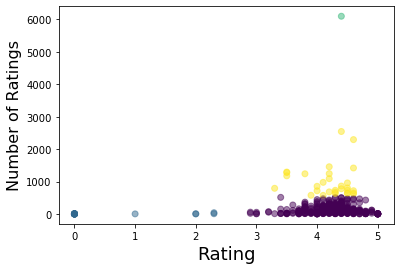

In [44]:

plt.scatter(coffee_df['Rating'],coffee_df['User_ratings_total'], c=coffee_df['Cluster_Labels'].astype(np.float), alpha=0.5)
plt.xlabel('Rating', fontsize=18)
plt.ylabel('Number of Ratings', fontsize=16)
plt.savefig('Final_Visualizations/Cluster_Rating')
plt.show()

In [52]:
Labels = []
Colors = []
for i in range(len(coffee_df)):
    if coffee_df['Cluster_Labels'][i] ==2:
        Labels.append('Very Popular')
        Colors.append('blue')
    elif coffee_df['Cluster_Labels'][i] ==3:
        Labels.append('Popular')
        Colors.append('green')
    elif coffee_df['Cluster_Labels'][i] ==0:
        Labels.append('Average')
        Colors.append('yellow')
    elif coffee_df['Cluster_Labels'][i] ==1:
        Labels.append('Less than Average')
        Colors.append('red')
coffee_df['Grouping'] = Labels
coffee_df['Color_Labels'] = Colors
coffee_df.to_csv('final_cluster_data.csv')

<strong><p> Every time I run I have to reassign labels to correct the clusters </p></strong>

In [53]:
coffee_zip = []
temp_zip = []
for i in range(coffee_df['Address'].count()):
    address = coffee_df['Address'][i].rsplit()
    temp_zip.append(address[-3])
for i in temp_zip:
    new_i=i.replace(",","")
    coffee_zip.append(new_i)
coffee_df['Zipcode'] =coffee_zip
coffee_df.head()

,Address,Latitude,Longitude,Name,Price_Level,Rating,Types,User_ratings_total,Cluster_Labels,Zipcode,Grouping,Color_Labels
0,"1 W Portal Ave, San Francisco, CA 94127, Unite...",37.740635,-122.465680,Squat & Gobble,2.0,4.1,"['restaurant', 'food', 'point_of_interest', 's...",472,0,94127,Average,yellow
1,"201 Spear St Suite 100, San Francisco, CA 9410...",37.791311,-122.392268,Starbucks,2.0,4.2,"['cafe', 'food', 'point_of_interest', 'store',...",319,0,94105,Average,yellow
2,"505 Howard St, San Francisco, CA 94105, United...",37.788088,-122.396006,Red Door Coffee,2.0,4.4,"['cafe', 'food', 'point_of_interest', 'store',...",111,0,94105,Average,yellow
3,"111 Minna St, San Francisco, CA 94105, United ...",37.787405,-122.399280,Red Door Coffee,2.0,4.3,"['cafe', 'food', 'point_of_interest', 'store',...",178,0,94105,Average,yellow
4,"199 Fremont St Unit 110, San Francisco, CA 941...",37.789905,-122.394609,Starbucks,2.0,4.5,"['cafe', 'food', 'point_of_interest', 'store',...",117,0,94105,Average,yellow


In [100]:
temp = coffee_df[coffee_df['Cluster_Labels']==0].groupby(['Zipcode','Grouping'])['Cluster_Labels'].count().to_frame()
temp1 = coffee_df[coffee_df['Cluster_Labels']==1].groupby(['Zipcode','Grouping'])['Cluster_Labels'].count().to_frame()
temp2 = coffee_df[coffee_df['Cluster_Labels']==2].groupby(['Zipcode','Grouping'])['Cluster_Labels'].count().to_frame()
temp3 = coffee_df[coffee_df['Cluster_Labels']==3].groupby(['Zipcode','Grouping'])['Cluster_Labels'].count().to_frame()
temp_list =[temp,temp1,temp2,temp3]
for i in temp_list:
    i.reset_index(inplace=True)
for i in range(len(temp_list)):
    temp_list[i].rename(columns={'Zipcode': 'Zipcode: {}'.format(i),'Cluster_Labels':' Count of Cluster Type: {}'.format(temp_list[i]['Grouping'][0])}, inplace=True)
for i in range(len(temp_list)):
     temp_list[i].drop('Grouping', axis=1,inplace=True)
final = pd.concat(temp_list,axis=1,sort=False)
final.drop([ 'Zipcode: 1','Zipcode: 2','Zipcode: 3'],axis=1,inplace=True)
final.rename(columns={'Zipcode: 0':'Zipcode'},inplace=True)
final=final.fillna(0)
final

,Zipcode,Count of Cluster Type: Average,Count of Cluster Type: Less than Average,Count of Cluster Type: Very Popular,Count of Cluster Type: Popular
0,94010,4,1.0,1.0,1.0
1,94014,4,1.0,0.0,3.0
2,94030,8,2.0,0.0,2.0
3,94032,1,1.0,0.0,1.0
4,94066,5,1.0,0.0,2.0
5,94080,3,1.0,0.0,1.0
6,94102,18,1.0,0.0,2.0
7,94103,18,2.0,0.0,1.0
8,94104,16,1.0,0.0,1.0
9,94105,17,7.0,0.0,3.0


In [101]:
zip_avg = coffee_df.groupby('Zipcode').agg({'Name':'count','Rating':'mean'})
zip_avg.rename(columns={'Name':'Number of Coffee Shops','Rating':'Average Rating'},inplace=True)
zip_avg.reset_index(inplace=True)
final = final.merge(zip_avg, on='Zipcode')
final_zip_data = final_data.merge(final,on='Zipcode')
final_zip_data.to_csv('final_zip_data.csv')

In [28]:
final_zip_data.to_csv('final_zip_data.csv')

<h3> Visualizations <h3/>

In [109]:
final_cluster = pd.read_csv('final_cluster_data.csv')
final_cluster.drop('Unnamed: 0',axis=1,inplace=True)

In [110]:
final_zip = pd.read_csv('final_zip_data.csv')
final_zip.drop('Unnamed: 0',axis=1,inplace=True)

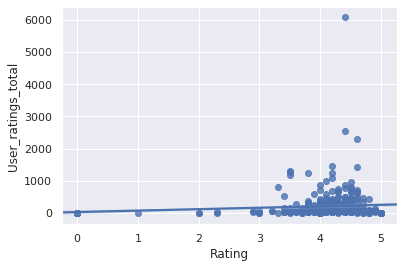

In [130]:
sns.regplot(x=final_cluster['Rating'], y=final_cluster['User_ratings_total'])
#coffee_df.head()

In [181]:
final_zip.head()

,Zipcode,Location,City,Population,Avg_Income_Per_House,National_Rank,number_of_crimes,Count of Cluster Type: Average,Count of Cluster Type: Less than Average,Count of Cluster Type: Very Popular,Count of Cluster Type: Popular,Number of Coffee Shops,Average Rating
0,94127,"37.736535, -122.457320","San Francisco, California",20624.0,95313.0,#350,29.0,1,0.0,0.0,0.0,1,4.100000
1,94105,"37.789168, -122.395009","San Francisco, California",2058.0,88976.0,#488,76.0,17,7.0,0.0,3.0,19,4.073684
2,94123,"37.800254, -122.436975","San Francisco, California",22903.0,84710.0,#633,65.0,12,0.0,0.0,0.0,12,4.383333
3,94130,"37.820894, -122.369725","San Francisco, California",1453.0,80959.0,#785,5.0,5,0.0,0.0,0.0,7,3.814286
4,94131,"37.746699, -122.442833","San Francisco, California",27897.0,76044.0,"#1,042",24.0,1,0.0,0.0,0.0,1,4.900000


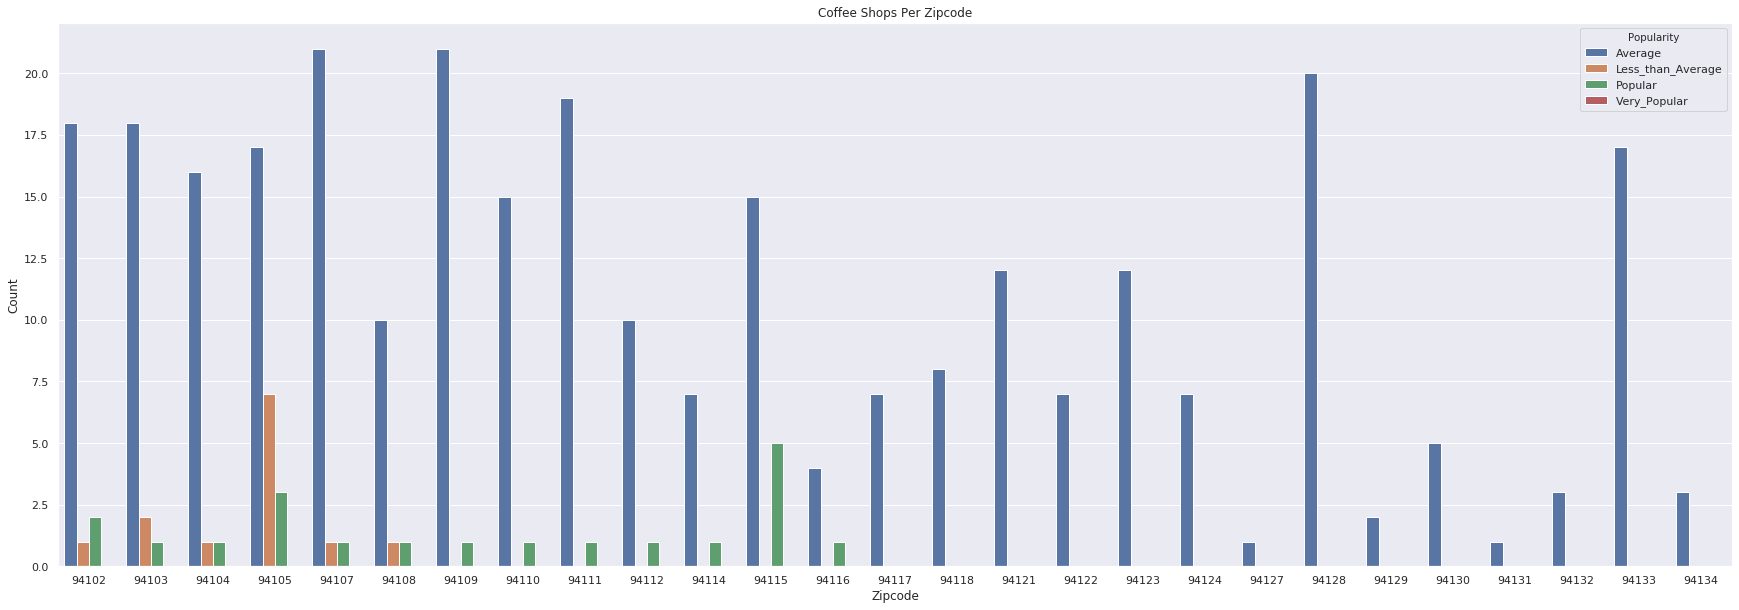

In [179]:
%matplotlib inline
sns.set()
df = final_zip[['Zipcode', ' Count of Cluster Type: Average',
       ' Count of Cluster Type: Less than Average',
       ' Count of Cluster Type: Popular',
       ' Count of Cluster Type: Very Popular', ]]
df.rename(columns={' Count of Cluster Type: Average':'Average',
       ' Count of Cluster Type: Less than Average':'Less_than_Average',
       ' Count of Cluster Type: Popular':'Popular',
       ' Count of Cluster Type: Very Popular':'Very_Popular'}, inplace=True)
df = pd.melt(df, id_vars='Zipcode', var_name='Popularity', value_name='Count')
df.Count =df.Count.astype(int)
fig,ax = plt.subplots(1,figsize=(30,10))
g = sns.catplot(ax=ax,x='Zipcode',y='Count', hue='Popularity', data=df,kind='bar')
ax.set_title('Coffee Shops Per Zipcode')
plt.close(2)
plt.savefig('Final_Visualizations/Shops_per_zip.png')
plt.show()

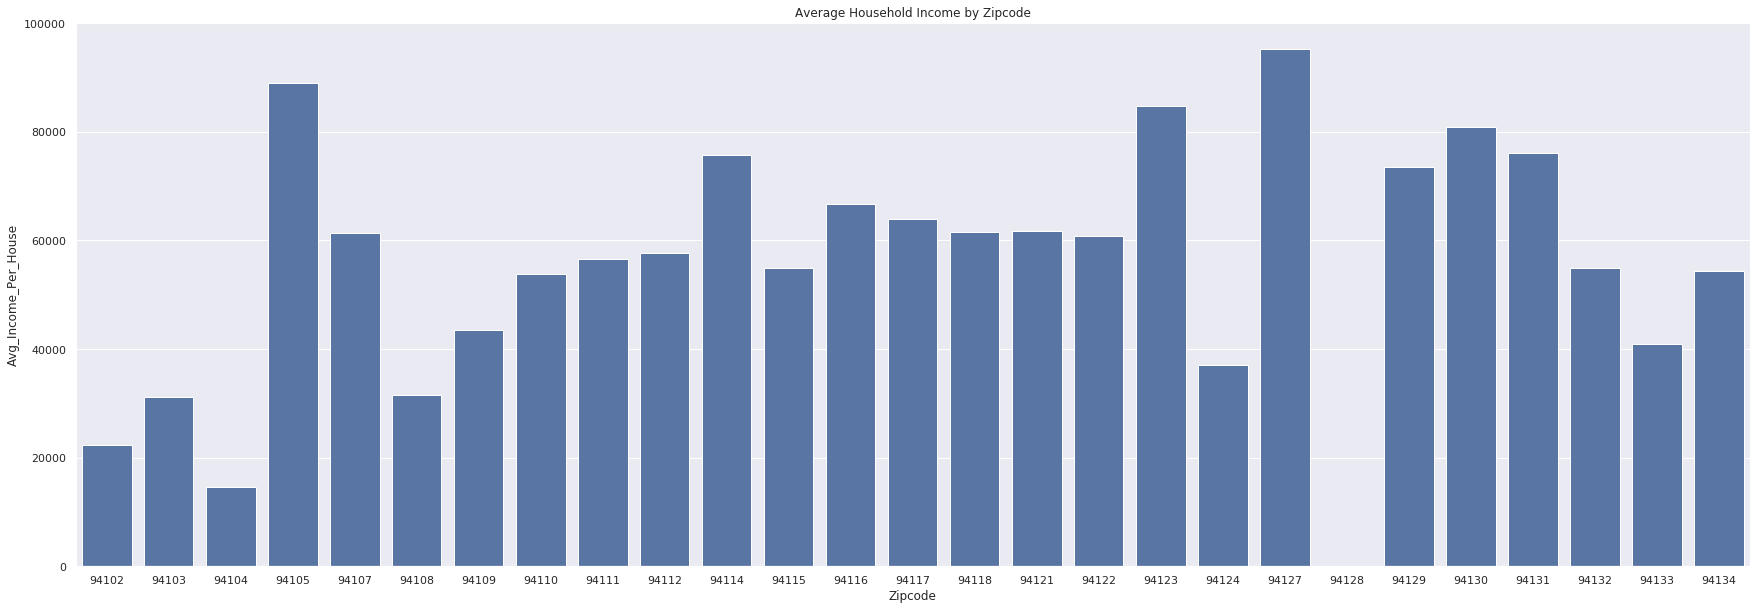

In [237]:
fig,ax = plt.subplots(1,figsize=(30,10))
sns.catplot(ax=ax,x='Zipcode', y='Avg_Income_Per_House', data=final_zip,kind='bar', color='b')
ax.set_title('Average Household Income by Zipcode')
plt.close(2)
plt.savefig('Final_Visualizations/AHI.png')
plt.show()

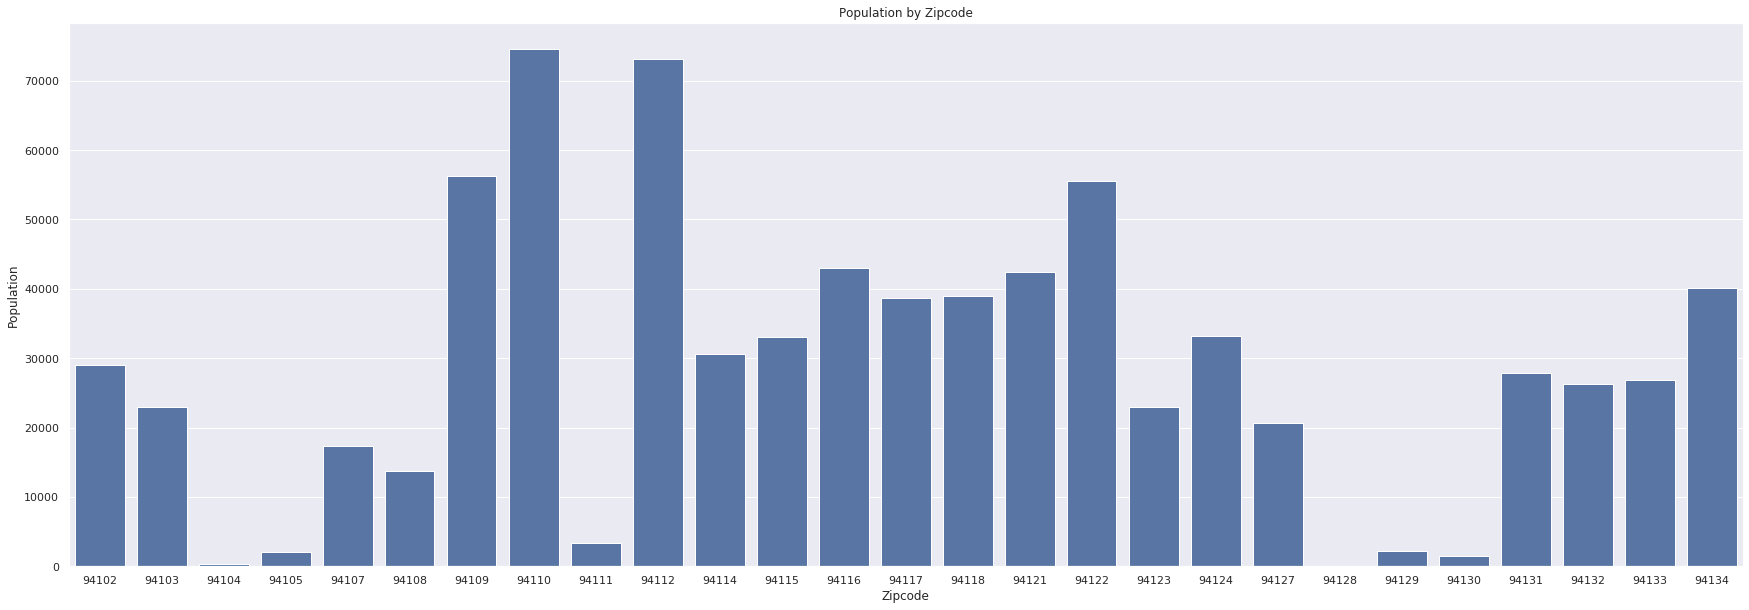

In [238]:
fig,ax = plt.subplots(1,figsize=(30,10))
sns.catplot(ax=ax,x='Zipcode', y='Population', data=final_zip,kind='bar', color='b')
ax.set_title('Population by Zipcode')
plt.close(2)
plt.savefig('Final_Visualizations/Population_by_Zipcode')
plt.show()

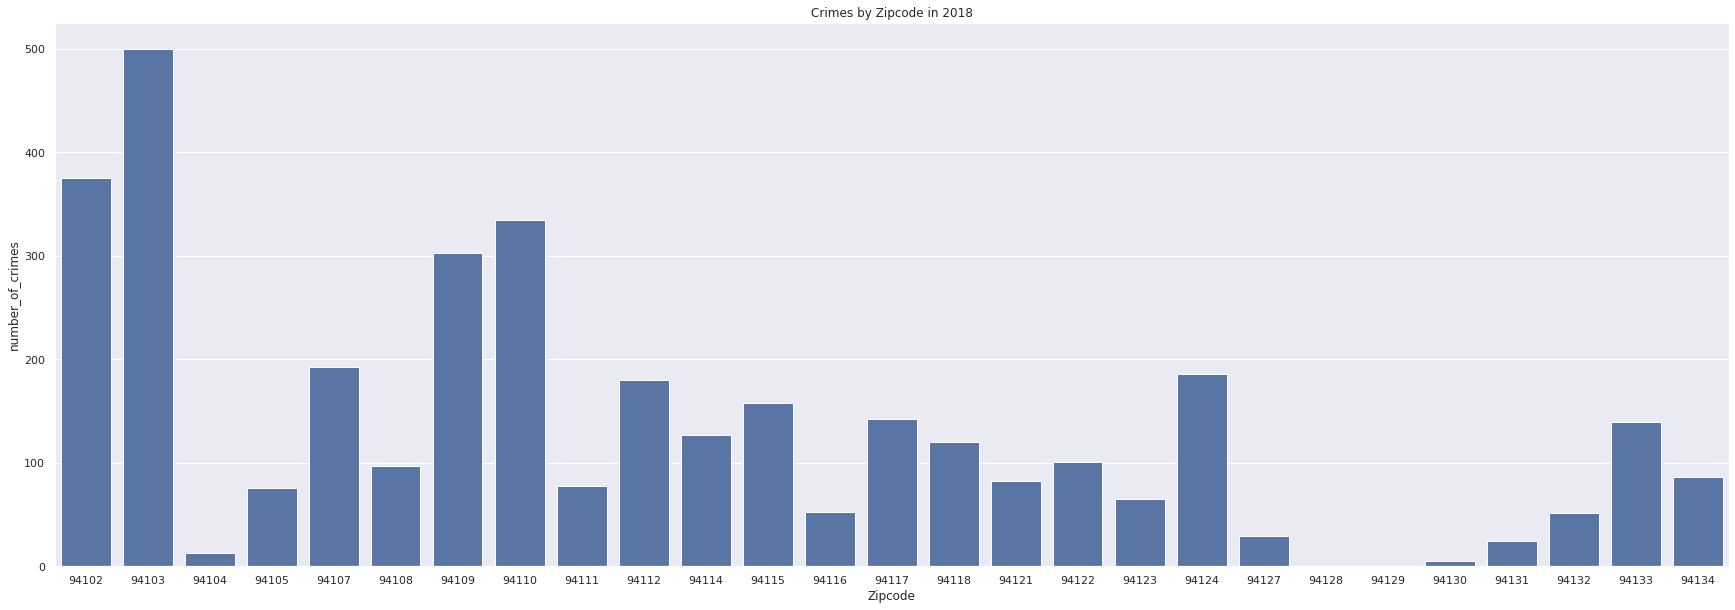

In [241]:
fig,ax = plt.subplots(1,figsize=(30,10))
sns.catplot(ax=ax,x='Zipcode', y='number_of_crimes', data=final_zip,kind='bar', color='b')
ax.set_title('Crimes by Zipcode in 2018')
plt.close(2)
plt.savefig('Final_Visualizations/Crime_zip')
plt.show()

In [195]:
!wget -O california.geojson https://raw.githubusercontent.com/OpenDataDE/State-zip-code-GeoJSON/master/ca_california_zip_codes_geo.min.json

--2019-11-26 21:01:13--  https://raw.githubusercontent.com/OpenDataDE/State-zip-code-GeoJSON/master/ca_california_zip_codes_geo.min.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.192.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.192.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 71207622 (68M) [text/plain]
Saving to: ‘california.geojson’

california.geojson  100%[===================>]  67.91M  76.1MB/s    in 0.9s    

2019-11-26 21:01:14 (76.1 MB/s) - ‘california.geojson’ saved [71207622/71207622]



In [199]:
import geopandas as gp
california_geo = 'california.geojson'
california_df= gp.read_file(california_geo)
zipcode_list = final_data['Zipcode'].to_list()
california_df = california_df[california_df.ZCTA5CE10.isin(zipcode_list)]
california_df.reset_index(inplace=True)
california_df.to_file('san_fran.json', driver="GeoJSON")

<h5>Map Visualizations</h5>

In [234]:
import folium
from folium.plugins import MarkerCluster
final_zip.Zipcode = final_zip.Zipcode.astype(str)
shp = 'san_fran.json'
m = folium.Map(location=[37.7049,-122.4194],zoom_start=12, tiles='Stamen Terrain')
m.choropleth(
    geo_data=shp,
    name='Population',
    data=final_zip,
    columns=['Zipcode','Population'],
    key_on='feature.properties.ZCTA5CE10',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name='Population of Zipcode',
    highlight=True,
    )
m.choropleth(
    geo_data=shp,
    name='Crime',
    data=final_zip,
    columns=['Zipcode','number_of_crimes'],
    key_on='feature.properties.ZCTA5CE10',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name='Number of Crimes',
    highlight=True
    )
m.choropleth(
    geo_data=shp,
    name='Income',
    data=final_zip,
    columns=['Zipcode','Avg_Income_Per_House'],
    key_on='feature.properties.ZCTA5CE10',
    fill_color='GnBu',
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name='Average Income',
    highlight=True
    )
for lat,lng, n, rating, price, color,group,c_label in zip(coffee_df['Latitude'],coffee_df['Longitude'],coffee_df['Name'],coffee_df['Rating'],coffee_df['Price_Level'],coffee_df['Color_Labels'],coffee_df['Grouping'],coffee_df['Cluster_Labels']):
    label = 'Name: {}, Rating: {}, Price: {}, Grouping: {}'.format(n,rating,price,group)
    label = folium.Popup(label,parse_html=True)
    color = color
    folium.CircleMarker([lat,lng],radius=5,popup=label,color='black',fill=True,fill_color=color,fill_opacity=1).add_to(m)
folium.LayerControl().add_to(m)
m.save(outfile='map.html')
m